# City Lines Data Analysis

> This notebook was created as part of the examination requirements of "Information Structures and Implications" class offered by the Master of Digital Humanities programme in KU Leuven.

## What's this notebook about?

Often times it is thought that the complexity level of a city's transportation systems is linked to that city's level of "development". We want to investigate whether this widely-held belief holds true by interrogating the city lines dataset and combining it with other datasets which can inform us about human development. While doing this, we also want to uncover some less-known facts about metro systems such as dominant colors and crowdedness.

The questions that we will ask are as follows: 

1. Is the education level of a country related to its total railway length?
2. Is the subjective well-being of a country related to its total railway length?
3. Is personal mobile phone ownership related to the variety of transportation modes in a country?
4. Are freedom of speech rankings related to the variety of transportation modes in a country?
5. Is there a relationship in between country and the time it takes to finish the construction of a railway station?
6. Are there any “late bloomer” cities? Cities that started building up their metro system late but have quickly built up many lines and stations.
7. What are the most “crowded” (short line, lots of stations) and the most “spacious” (long line, barely no stations) lines?
8. What are some unique hues that nobody uses in coloring their metro lines?
9. Is there a correlation between the age of a line and its color?
10. What is the most popular line color for each city?

## Code

### Setup

#### Import the required packages

In [1]:
from pathlib import Path
import mysql.connector as connector
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl


#### Establish connection with the database

In [2]:
credentials = {
    "username": "root",
    "password": ""
}

conn = connector.connect(user=credentials["username"],
                         passwd=credentials["password"],
                         host="localhost",
                         database="city_lines")

#### Configure visualization presets

In [3]:
# Figure
mpl.rcParams["figure.facecolor"] = "1A1C1A"
mpl.rcParams["figure.edgecolor"] = "1A1C1A"

# Axes
mpl.rcParams["axes.facecolor"] = "1A1C1A"
mpl.rcParams["axes.edgecolor"] = "DBDDDB"
mpl.rcParams["axes.labelcolor"] = "DBDDDB"

# Ticks
mpl.rcParams["xtick.color"] = "DBDDDB"
mpl.rcParams["ytick.color"] = "DBDDDB"

# Typography
mpl.rcParams["font.family"] = "Arial"
mpl.rcParams["font.size"] = 12
mpl.rcParams["text.color"] = "DBDDDB"


### Analysis

#### Question four 

> ***Is personal mobile phone ownership related with the variety of transportation modes in a country?***

In [4]:
sql_query = """
SELECT c.country,
       COUNT(DISTINCT(l.transport_mode_id)) AS tr_mode_variation, 
       m.lines_per_hundred
  FROM cities c
       JOIN mobile_phone_usage m ON (c.country = m.country)
       JOIN `lines` l ON (c.id = l.city_id)
       JOIN transport_modes tm on (l.transport_mode_id = tm.id )
 WHERE tm.id != 0
 GROUP BY c.country
 ORDER BY tr_mode_variation DESC;
"""

result = pd.read_sql(sql_query, conn)
result

,country,tr_mode_variation,lines_per_hundred
0,Chile,7,122.90
1,France,7,114.20
2,United States,7,103.10
3,Mexico,6,90.20
4,Japan,4,115.20
5,Argentina,4,141.34
6,Brazil,4,141.30
7,Australia,3,87.60
8,Sweden,2,146.40
9,Singapore,2,150.10


#### Question five

> ***What is the average station completion time for each city?***

##### English explanation

###### SQL explanation

###### Python explanation



In [5]:
sql_query = """
SELECT c.name, AVG(((s.opening - s.buildstart))) AS avg_const_dur
  FROM cities c
       JOIN stations s ON (c.id = s.city_id)
 GROUP BY c.name
 HAVING avg_const_dur NOT LIKE "NaN"
        AND avg_const_dur > 0
 ORDER BY avg_const_dur;
"""

result = pd.read_sql(sql_query, conn)
result

,name,avg_const_dur
0,Valparaíso,0.0137
1,Osaka,0.1674
2,Graz,0.1948
3,Chicago,0.2857
4,Newcastle-on-Tyne,0.4912
5,Concepción,0.6170
6,Tokyo,0.7150
7,Bogotá,1.0000
8,Ottawa,1.0000
9,Montpellier,1.0500


#### Question eight

> ***What are some unique hues that nobody uses in coloring their metro lines?***

This can be tackled in two ways:
- Comparing hex code colors outright without any conversion and selecting the least repeating
- Using color transformation to calculate the "mean" color and selecting the values that are farthest from it.

The first approach would be a naive one: counting individual hexcodes would reflect only orthographic diversity and uniqueness, not actual color uniqueness. The color #000000 and #100000 have different hexcode representations but they are perceptually very similar. What we are looking for is perceptual uniqueness and for that we need to use the second approach.

##### English explanation - first approach

###### SQL explanation

###### Python explanation

##### English explanation - second approach

###### SQL explanation

###### Python explanation

##### Code - first approach

In [6]:
sql_query = """
SELECT l.color, COUNT(l.color) as occurence_count
  FROM `lines` l
 GROUP BY color
HAVING occurence_count = 1
"""

result = pd.read_sql(sql_query, conn)
result

,color,occurence_count
0,#000084,1
1,#0000cc,1
2,#000794,1
3,#000bbc,1
4,#001bff,1
...,...,...
590,#ffdd00,1
591,#ffe700,1
592,#ffe900,1
593,#fff06e,1


##### Code - second approach

In [7]:
sql_query = """
SELECT l.color
  FROM `lines` l
"""

result = pd.read_sql(sql_query, conn)
result

,color
0,#00b3da
1,#f43e3c
2,#0071ae
3,#00826d
4,#7d308b
...,...
1338,#00baa5
1339,#f01008
1340,#0070c0
1341,#00b050


##### Interpretation of results

#### Question nine

> ***Is there a correlation between the age of a line and its color?***

##### English explanation

###### SQL explanation

Join the 'lines' table with the 'stations' table through the 'station_lines' table. Group first by line_id, then by line age. Select line id's and line colors. Calculate the line age for each line and station combination by substracting from the current date the station opening date. Also convert the hexcode color value into separate red, green and blue values in integer format. Order by line_id in ascending, and then by line age descending.

###### Python explanation

Read the resulting SQL table into a Python dataframe. Filter the dataframe by selecting only the oldest station + line combo. This way, we effectively select the true age for each line.



##### Interpretation of results

##### Code

In [8]:
sql_query = """
SELECT l.id AS line_id,
       l.color AS line_color,
       CONV(SUBSTRING(l.color, 2, 2), 16, 10) AS r_value,
       CONV(SUBSTRING(l.color, 4, 2), 16, 10) AS g_value,
       CONV(SUBSTRING(l.color, 4, 2), 16, 10) AS b_value,
      (2021 - s.opening) AS age
  FROM `lines` l
        JOIN station_lines sl ON (sl.line_id = l.id)
        JOIN stations s ON (s.id = sl.station_id )
 GROUP BY line_id, age
 ORDER BY line_id ASC, age DESC;
"""

result = pd.read_sql(sql_query, conn)

# The result needs further processing
max_mask = result.groupby("line_id")["age"].transform(max) == result["age"]
result = (result.loc[max_mask, :]
          .sort_values("age", ascending=False))
result.loc[:, ["r_value", "g_value", "b_value"]] = result.loc[:, ["r_value", "g_value", "b_value"]].astype(int)
result


,line_id,line_color,r_value,g_value,b_value,age
3553,1414,#000,0,0,0,187.0
3536,1410,#000,0,0,0,187.0
3565,1415,#000,0,0,0,186.0
1655,527,#280000,40,0,0,186.0
427,171,#0087ff,0,135,135,185.0
...,...,...,...,...,...,...
288,137,#827a04,130,122,122,1.0
2665,1072,#264494,38,68,68,1.0
2669,1075,#264494,38,68,68,1.0
951,323,#0786c9,7,134,134,1.0


##### Interpretation of results

#### Question ten

> ***What is the most popular line color for each country?***

##### English explanation

###### SQL explanation
Select each country from the cities table that appear more than twice in the "lines" table. This is a proxy for countries that have more than one transportation line logged into the database. Select color of the each line to represent the lines. Group by country first, then by color. Calculate how many times each color occurs within its country group, name this as "occurence_count"

###### Python explanation
We read the SQL table we get into a dataframe. To make our dataframe more intelligible, we first convert "occurence_count" to a percentage. Then we filter the dataframe to get only the most recurring color.
In the end, we have a dataframe of countries, their most popular line color and its occurence percentage.

##### Code

In [9]:
sql_query = """
SELECT x.country, z.color, COUNT(z.color) AS occurence_count
  FROM (SELECT c.country, COUNT(c.country)
          FROM cities c
               JOIN `lines` l ON (c.id = l.city_id)
         GROUP BY c.country
         HAVING COUNT(c.country) > 2) x
        JOIN cities y ON (x.country = y.country)
        JOIN `lines` z on (y.id = z.city_id)
 GROUP BY x.country, z.color
 ORDER BY x.country ASC, occurence_count DESC;
"""

result = pd.read_sql(sql_query, conn)

# The result needs further processing
perc = (result.groupby(["country"])["occurence_count"].max()
        / result.groupby(["country"])["occurence_count"].sum()*100) # Get the percentage versions
perc = pd.DataFrame(perc).reset_index()
max_mask = result.groupby("country")["occurence_count"].transform(max) == result["occurence_count"] # Select the max only
result = (result.loc[max_mask, :]
          .sort_values("country", ascending=True))
result = pd.merge(result, perc, on="country")
result = (result
          .drop("occurence_count_x", axis=1)
          .rename({"occurence_count_y": "occurence_perc"}, axis=1))
result


,country,color,occurence_perc
0,Argentina,#f3d379,42.857143
1,Australia,#000,48.888889
2,Austria,#000,55.000000
3,Belgium,#e5442e,13.636364
4,Belgium,#eabc00,13.636364
...,...,...,...
75,Singapore,#748477,33.333333
76,Spain,#159585,12.000000
77,Sweden,#bd10e0,25.000000
78,Sweden,#7ed321,25.000000


##### Interpretation of results

###### Visualization

In [10]:
# --- data prep ---
data = result

data_levels = []
data_levels.append(data)
i = 0
while sum(data_levels[i]["country"].duplicated()):
    mask = data_levels[i]["country"].duplicated()
    data_levels.append(data_levels[i].loc[mask, :])
    data_levels[i] = data_levels[i].loc[~mask, :]
    i += 1

unique_countries = sorted(set(result["country"].values))
positions = {}
i = 0
while i < len(unique_countries):
    positions[unique_countries[i]] =  i
    i += 1

positions
data_levels[1]

,country,color,occurence_perc
4,Belgium,#eabc00,13.636364
6,Bolivia,#47bbf4,9.090909
18,Canada,#f8e71c,7.407407
22,Colombia,#bd10e0,6.250000
38,Czech Republic,#f8e71c,25.000000
45,Hungary,#ff9f00,25.000000
51,Malaysia,#0300fa,11.111111
61,Netherlands,#4e8609,25.000000
66,Portugal,#670795,12.500000
74,Scotland,#417505,10.000000


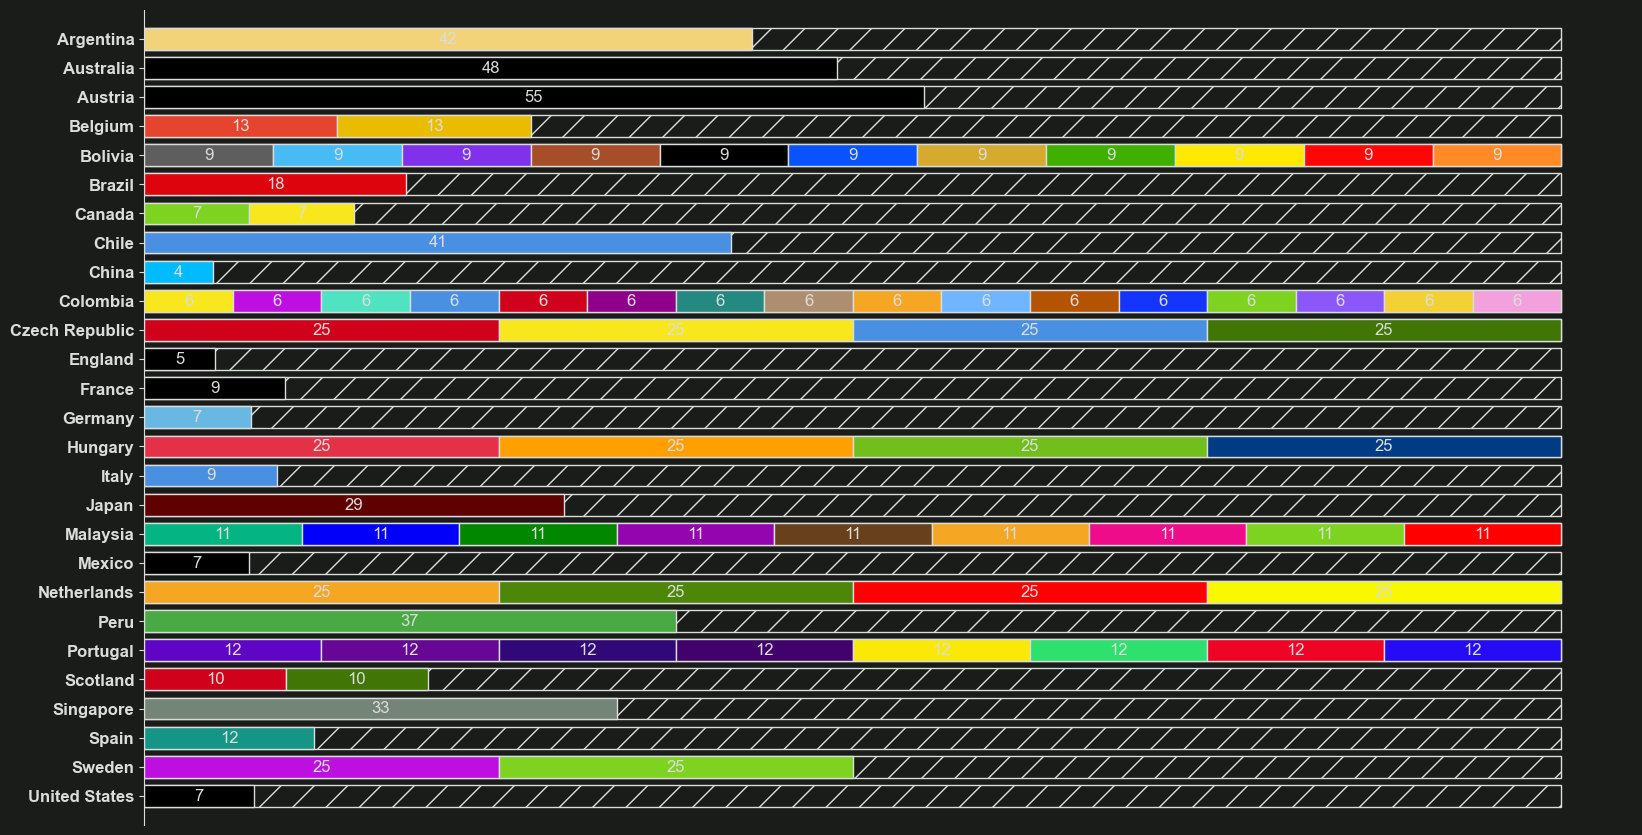

In [122]:

bar_labels = sorted(set(result["country"].values))
bar_positions = [i for i in range(0, len(bar_labels))]
bar_widths = [100 for label in bar_labels]
bar_colors = result["color"].values[:27]

# --- viz setup ---
# create figure
fig = plt.figure(figsize = (19.20, 10.80),
                 dpi = 100)
ax = fig.add_subplot(1, 1, 1)


# plot figure
ax.barh(y = bar_positions,
        width = bar_widths,
        color = "#FFFFFF00",
        hatch = "/",
        align = "center",
        height = 0.75,
        edgecolor = "#DBDDDB",
        linewidth = 1)


# configure params
# spines and axes
for spine in ["right", "top", "bottom"]:
    ax.spines[spine].set_visible(False)
ax.invert_yaxis()
ax.axes.set_ylim(27, -1)

# ticks and labels
ax.set_yticks(bar_positions)
ax.set_yticklabels(bar_labels,
                   fontweight = "bold")

ax.set_xticks([])
ax.set_xticklabels([])

ax.tick_params(axis = "x",
    which = "both",
    bottom = False,
    top = False,
    left = False,
    right = False)

i = 0
left_widths = data_levels[0].loc[:, ["country", "occurence_perc"]]
while i < len(data_levels):
    data_level = data_levels[i]
    bar_widths = data_level["occurence_perc"].values
    bar_labels = sorted(data_level["country"].values)
    opposite_mask = left_widths.loc[:, "country"].isin(data_level["country"])

    left_start = left_widths.loc[opposite_mask, "occurence_perc"].values if i > 0 else 0

    if i > 0:
        left_widths.loc[opposite_mask, "occurence_perc"] += bar_widths

    bar_positions = [positions[name] for name in bar_labels]
    bar_colors = data_level["color"]


    bar = ax.barh(y = bar_positions,
            height = 0.75,
            width = bar_widths,
            left = left_start,
            color = bar_colors,
            align = "center",
            edgecolor = "#DBDDDB",
            linewidth = 1)

    ax.bar_label(bar, bar_widths.astype(int), label_type="center", fmt='%.2f')
    i += 1
